In [1]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [9]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

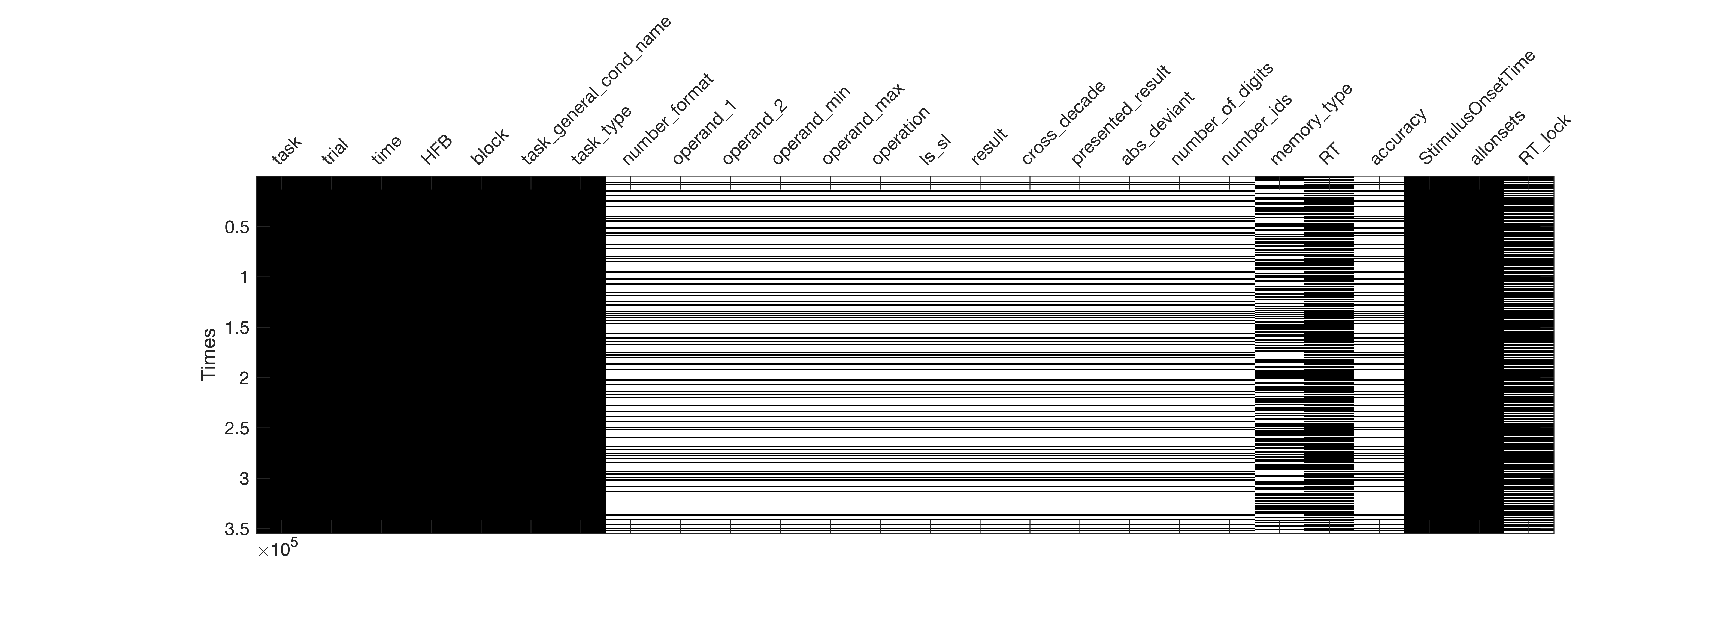

In [3]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [15]:
#data = np.genfromtxt('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data.csv', delimiter=',')
data = pd.read_csv('/Users/pinheirochagas/Pedro/drive/Stanford/projects/math_network/encoding_model/data_61.csv') 


In [16]:
# Set extreme values to zero
data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
# Recode task name
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1


### Plot all blocks concatenated

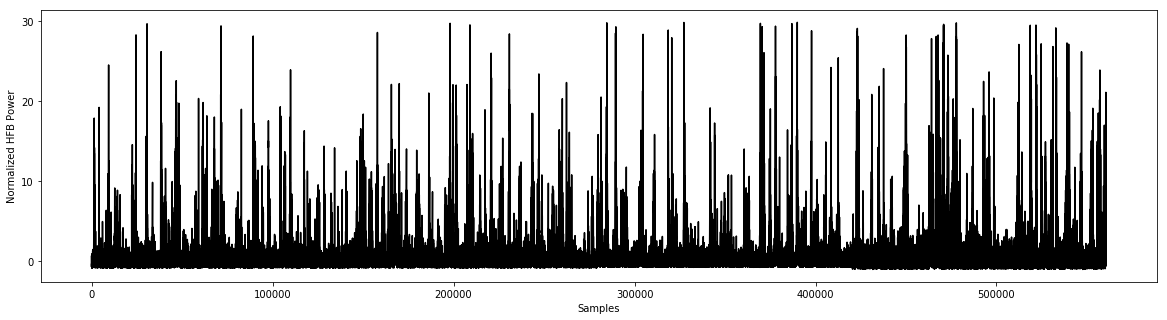

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data.loc[:,'HFB'], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

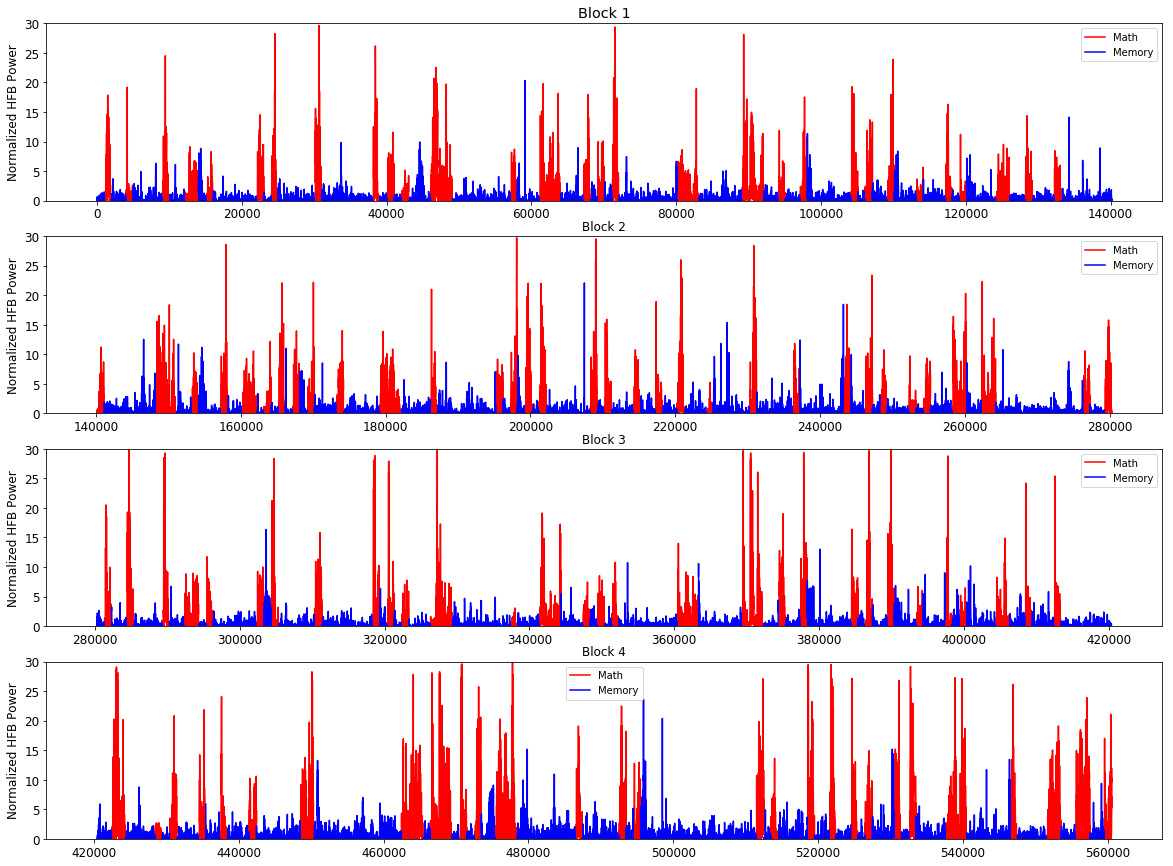

In [154]:
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = data.loc[:,'HFB'].copy()
math_trials[data.loc[:,'task_general_cond_name']!=2] = np.nan
memo_trials = data.loc[:,'HFB'].copy()
memo_trials[data.loc[:,'task_general_cond_name']!=1] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(math_trials[data.loc[:,'block']==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data.loc[:,'block']==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    #ax[i].set_xlabel('Samples')
    ax[i].set_ylabel('Normalized HFB Power')
    plt.rcParams.update({'font.size': 10}) 
    ax[i].legend()


([<matplotlib.axis.YTick at 0x1c4540a6d8>,
 <a list of 2 Text yticklabel objects>)

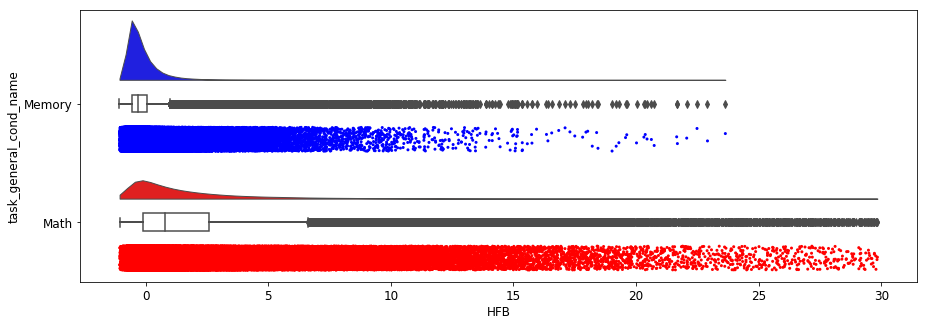

In [36]:
# Overall activity 
my_pal = {1: 'blue', 2: 'red'}
f, ax = plt.subplots(figsize=(15, 5))
ax=pt.RainCloud(x = 'task_general_cond_name', y = 'HFB', data = data, palette = my_pal, bw = 0.1,
                 width_viol = 1, ax = ax, orient = 'h', move = .3)
plt.rcParams.update({'font.size': 12}) 
plt.yticks(np.arange(2), ('Memory', 'Math'))

### Selec the main feature: task:

In [79]:
features = np.array(data.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

In [80]:
np.shape(features_reshape)

(560, 1, 1001)

#### Add a series of delayed versions of this feature

In [82]:
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)
delays = np.linspace(-1, 0., 100)
X_delayed = delay_time_series(features_reshape, delays, 500)

Text(0.5,1,'Time-Delayed Task Name')

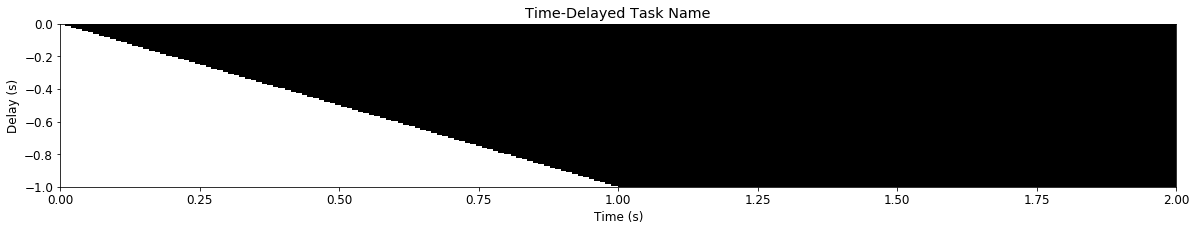

In [83]:
# Plot
times = np.unique(data.loc[:,'time'])
fig, ax = plt.subplots(figsize=(20, 3))
ax.pcolormesh(times, delays,
              X_delayed[1,0,:,:], cmap='binary')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Task Condition')

In [84]:
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

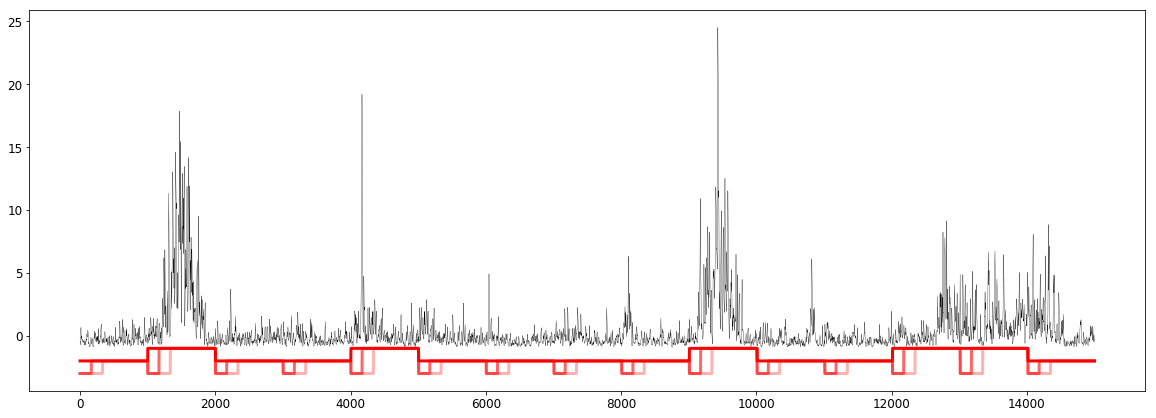

In [144]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = plt.plot(data.loc[0:15000,'HFB'], 'k', linewidth=0.3)
ax = plt.plot(X_env[0:15000,99]-3, color = [1, 0, 0, 1], linewidth=3)
ax = plt.plot(X_env[0:15000,66]-3, color = [1, 0, 0, 0.6], linewidth=3)
ax = plt.plot(X_env[0:15000,33]-3, color = [1, 0, 0, 0.3], linewidth=3)

In [145]:
# Define the dependent variable
y = np.array(data.loc[:,'HFB']) # HFB

In [146]:
# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

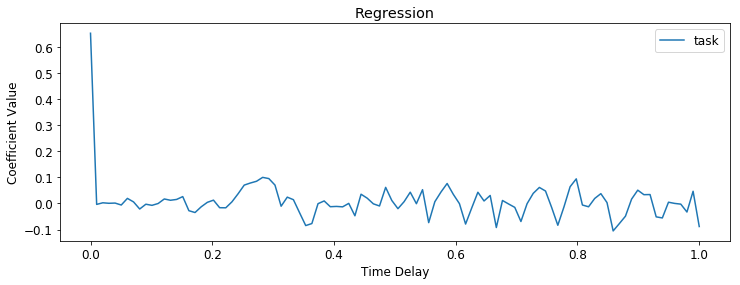

In [153]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [149]:
# Choose another feature
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
features = np.array(data.loc[:,'result'])

features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)
X_delayed = delay_time_series(features_reshape, delays, 500)
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

est_res = make_pipeline(StandardScaler(), LinearRegression())
est_res.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

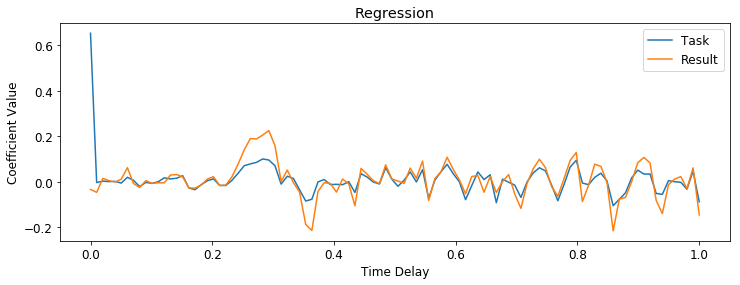

In [152]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'Task')
ax.plot(np.abs(delays), est_res.steps[-1][-1].coef_,label = 'Result')
#ax.plot(np.abs(delays), est_cd.steps[-1][-1].coef_,label = 'Cross decade')
#ax.plot(np.abs(delays), est_task.steps[-1][-1].coef_,label = 'Task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()